# Did Kobe Bryant sink the shot


In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# initiate our session and read the main CSV file, then we print the dataframe schema

spark = SparkSession.builder.appName('imbalanced_binary_classification').getOrCreate()
df = spark.read.csv('data.csv', header=True, inferSchema=True)

### MLlib uses only "features" and "labels" columns.

In [3]:
#Rename the shot_made_flag to "label", as required
df = df.withColumnRenamed('shot_made_flag', 'label')
df.printSchema()

root
 |-- action_type: string (nullable = true)
 |-- combined_shot_type: string (nullable = true)
 |-- game_event_id: integer (nullable = true)
 |-- game_id: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- loc_x: integer (nullable = true)
 |-- loc_y: integer (nullable = true)
 |-- lon: double (nullable = true)
 |-- minutes_remaining: integer (nullable = true)
 |-- period: integer (nullable = true)
 |-- playoffs: integer (nullable = true)
 |-- season: string (nullable = true)
 |-- seconds_remaining: integer (nullable = true)
 |-- shot_distance: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- shot_type: string (nullable = true)
 |-- shot_zone_area: string (nullable = true)
 |-- shot_zone_basic: string (nullable = true)
 |-- shot_zone_range: string (nullable = true)
 |-- team_id: integer (nullable = true)
 |-- team_name: string (nullable = true)
 |-- game_date: timestamp (nullable = true)
 |-- matchup: string (nullable = true)
 |-- opponent: string (

In [4]:
new_df = df
pdf = df.toPandas()

In [5]:
random_sample = pdf.take(np.random.permutation(len(pdf))[:3])
random_sample.T

,10644,14136,3621
action_type,Jump Shot,Turnaround Fadeaway shot,Driving Layup Shot
combined_shot_type,Jump Shot,Jump Shot,Layup
game_event_id,216,311,33
game_id,20600738,20800721,20200326
lat,33.8343,33.9013,34.0443
loc_x,82,-111,0
loc_y,210,143,0
lon,-118.188,-118.381,-118.27
minutes_remaining,1,8,7
period,2,3,1


In [6]:
#Get rid of columns we do not want to train with
#drop_col = ['game_id','game_event_id','team_id','team_name','game_date','combined_shot_type','lat','lon','shot_zone_basic','shot_id']
drop_col = ['game_id','game_event_id','team_id','team_name','game_date','lat','lon','shot_id','combined_shot_type']

#we will drop them all later
#new_df = new_df.select([column for column in new_df.columns if column not in drop_col])

In [7]:
drop_col

['game_id',
 'game_event_id',
 'team_id',
 'team_name',
 'game_date',
 'lat',
 'lon',
 'shot_id',
 'combined_shot_type']

### Data Science

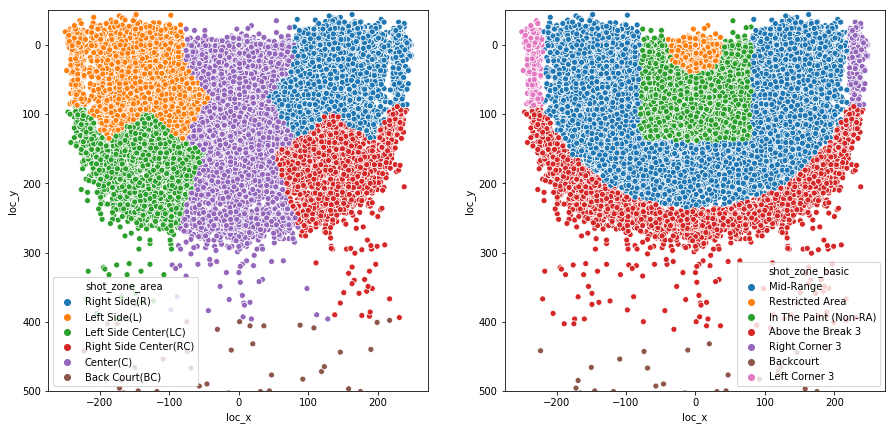

In [8]:
#sns.set_style('whitegrid')
plt.subplots(1, 2, figsize=(15, 7), sharey=True)
plt.subplot(121)
plt.ylim(500, -50)
sns.scatterplot(x="loc_x", y="loc_y", hue="shot_zone_area", data=pdf)
plt.subplot(122)
plt.ylim(500, -50)
sns.scatterplot(x="loc_x", y="loc_y", hue="shot_zone_basic", data=pdf)

#### convert matchup column to home game indicator

In [9]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import rank,sum,col
from pyspark.sql.functions import udf
import re
re_at = re.compile('@')

def do_matchup(label):
    if re_at.search(label):
        return 0
    else: 
        return 1

do_matchup_udf = udf(lambda x: do_matchup(x), IntegerType())
new_df = new_df.withColumn('home_game', do_matchup_udf(col('matchup')))


In [10]:
drop_col.append('matchup')

#### convert minutes and seconds remaining into a time_remaining column

In [11]:
def do_time(_min,_sec):
    return 60*_min + _sec

do_time_udf = udf(do_time, IntegerType())
new_df = new_df.withColumn('time_remaining', do_time_udf('minutes_remaining','seconds_remaining') )

In [12]:
drop_col += ['minutes_remaining','seconds_remaining']

In [13]:
season_udf = udf(lambda x: int(x[:4]), IntegerType())
new_df = new_df.withColumn('season_num', season_udf(col('season')))
drop_col += ['season']

In [14]:
from pyspark.sql.types import FloatType
def do_dist(_x,_y):
    return float(np.sqrt(float((_x/10)**2) + float((_y/10)**2)))
    
distance_udf = udf(do_dist, FloatType())
new_df = new_df.withColumn("hoop_distance", distance_udf("loc_x","loc_y"))
drop_col += ['shot_distance']

In [15]:
new_df.groupby('shot_zone_range').count().show()
drop_col += ['shot_zone_range']

+---------------+-----+
|shot_zone_range|count|
+---------------+-----+
|Back Court Shot|   83|
|       8-16 ft.| 6626|
|        24+ ft.| 6275|
|Less Than 8 ft.| 9398|
|      16-24 ft.| 8315|
+---------------+-----+



In [16]:
area_group = pdf.groupby('shot_zone_area')
basic_group = pdf.groupby('shot_zone_basic')

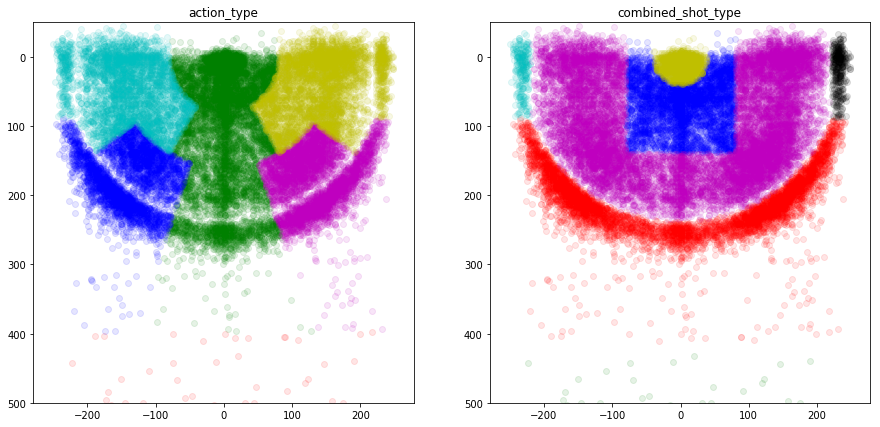

In [17]:
plt.subplots(1, 2, figsize=(15, 7), sharey=True)
colors = list('rgbcmyk')

plt.subplot(121)
plt.ylim(500, -50)
plt.title('action_type')
for i, (_, area) in enumerate(area_group):
    plt.scatter(area['loc_x'], area['loc_y'], alpha=0.1, color=colors[i])
    
plt.subplot(122)
plt.ylim(500, -50)
plt.title('combined_shot_type')
for i, (_, basic) in enumerate(basic_group):
    plt.scatter(basic['loc_x'], basic['loc_y'], alpha=0.1, color=colors[i])

### Check out the possible label values

In [18]:
new_df.groupby('label').count().toPandas()

,label,count
0,NaN,5000
1,1.0,11465
2,0.0,14232


In [19]:
new_df = new_df.select([column for column in new_df.columns if column not in drop_col])

In [37]:
drop_col

['game_id',
 'game_event_id',
 'team_id',
 'team_name',
 'game_date',
 'lat',
 'lon',
 'shot_id',
 'combined_shot_type',
 'matchup',
 'minutes_remaining',
 'seconds_remaining',
 'season',
 'shot_distance',
 'shot_zone_range']

### The null value labels, are the data we need to make predictions on, for the competition

In [20]:
val_df = new_df.filter('label is null')

### Determine if the data is balanced or imbalanced. Use 70%-30% as the threshold

In [21]:
ones = new_df.filter("label=1").count()
zeros = new_df.filter("label=0").count()

total = ones + zeros
print('all: {}'.format(total))
print('ones: {}'.format(ones))
print('zeros: {}'.format(zeros))
ratio = round(zeros/total,2)
print('ratio is: {}'.format(ratio))

imbalanced = False
if ratio > .7:
    imbalanced = True
    print('This is an imbalanced dataset: {}'.format(ratio))
else:
    imbalanced = False
    print('This is not an imbalanced dataset: {}'.format(ratio))

all: 25697
ones: 11465
zeros: 14232
ratio is: 0.55
This is not an imbalanced dataset: 0.55


In [22]:
val_df.count()

5000

In [23]:
new_df = new_df.na.drop()

25697


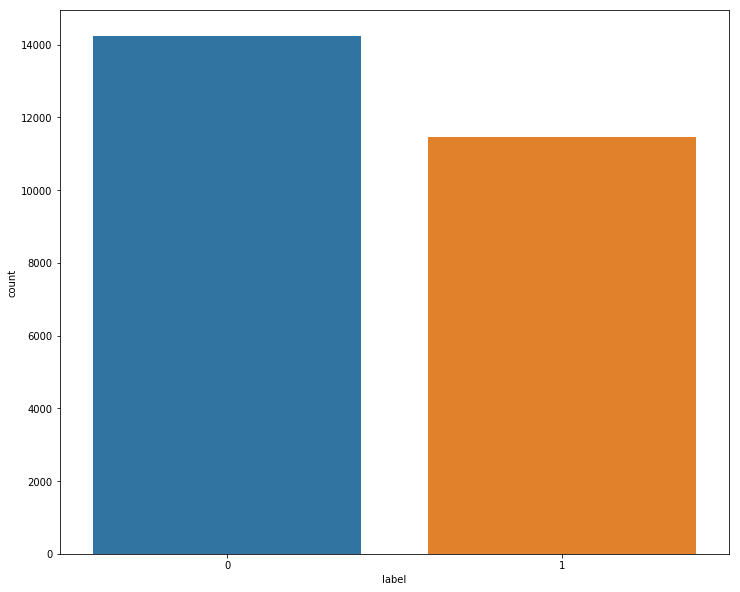

In [24]:
# let's have a look at the distribution of our target variable:
# to make it look better, we first convert our spark df to a Pandas df

df_pd = new_df.toPandas()
print(len(df_pd))
plt.figure(figsize=(12,10))
sns.countplot(x='label', data=df_pd, order=df_pd['label'].value_counts().index)

In [25]:
# let's see how everything look in Pandas
import pandas as pd
pd.DataFrame(new_df.take(10), columns= new_df.columns)

,action_type,loc_x,loc_y,period,playoffs,label,shot_type,shot_zone_area,shot_zone_basic,opponent,home_game,time_remaining,season_num,hoop_distance
0,Jump Shot,-157,0,1,0,0,2PT Field Goal,Left Side(L),Mid-Range,POR,0,622,2000,15.700000
1,Jump Shot,-101,135,1,0,1,2PT Field Goal,Left Side Center(LC),Mid-Range,POR,0,465,2000,16.860012
2,Jump Shot,138,175,1,0,0,2PT Field Goal,Right Side Center(RC),Mid-Range,POR,0,412,2000,22.286543
3,Driving Dunk Shot,0,0,2,0,1,2PT Field Goal,Center(C),Restricted Area,POR,0,379,2000,0.000000
4,Jump Shot,-145,-11,3,0,0,2PT Field Goal,Left Side(L),Mid-Range,POR,0,572,2000,14.541664
5,Layup Shot,0,0,3,0,1,2PT Field Goal,Center(C),Restricted Area,POR,0,532,2000,0.000000
6,Jump Shot,-65,108,3,0,1,2PT Field Goal,Left Side(L),In The Paint (Non-RA),POR,0,372,2000,12.605158
7,Running Jump Shot,-33,125,3,0,0,2PT Field Goal,Center(C),In The Paint (Non-RA),POR,0,216,2000,12.928264
8,Jump Shot,-94,238,3,0,0,3PT Field Goal,Left Side Center(LC),Above the Break 3,POR,0,116,2000,25.589060
9,Jump Shot,121,127,1,0,1,2PT Field Goal,Right Side Center(RC),Mid-Range,UTA,1,660,2000,17.541380


## Data Wrangling

In [26]:
for item in new_df.dtypes:
    print('{} : {}'.format(item[0], item[1]))

action_type : string
loc_x : int
loc_y : int
period : int
playoffs : int
label : int
shot_type : string
shot_zone_area : string
shot_zone_basic : string
opponent : string
home_game : int
time_remaining : int
season_num : int
hoop_distance : float


In [27]:
# we use the function below to find more information about the missing values

def info_missing_table(df_pd):
    """Input pandas dataframe and Return columns with missing value and percentage"""
    mis_val = df_pd.isnull().sum() #count total of null in each columns in dataframe
    mis_val_percent = 100 * df_pd.isnull().sum() / len(df_pd) #count percentage of null in each columns
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #join to left (as column) between mis_val and mis_val_percent
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'}) #rename columns in table
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)         
    print ("Your selected dataframe has " + str(df_pd.shape[1]) + " columns.\n"    #.shape[1] : just view total columns in dataframe  
    "There are " + str(mis_val_table_ren_columns.shape[0]) +              
    " columns that have missing values.") #.shape[0] : just view total rows in dataframe
    return mis_val_table_ren_columns

In [28]:
missings = info_missing_table(df_pd)
missings

Your selected dataframe has 14 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [29]:
# so this function deals with the a spark dataframe directly to find more about the missing values

def count_missings(spark_df):
    null_counts = []        
    for col in spark_df.dtypes:    
        cname = col[0]     
        ctype = col[1]      
        nulls = spark_df.where( spark_df[cname].isNull()).count() #check count of null in column name
        result = tuple([cname, nulls])  #new tuple, (column name, null count)
        null_counts.append(result)      #put the new tuple in our result list
    null_counts=[(x,y) for (x,y) in null_counts if y!=0]  #view just columns that have missing values
    return null_counts


In [30]:
miss_counts = count_missings(new_df)
miss_counts

[]

In [31]:
# here we seperate missing columns in our new_df based on categorical and numerical types

list_cols_miss=[x[0] for x in miss_counts]
df_miss= new_df.select(*list_cols_miss)
#categorical columns
catcolums_miss=[item[0] for item in df_miss.dtypes if item[1].startswith('string')]  #will select name of column with string data type
print("cateogrical columns_miss:", catcolums_miss)

### numerical columns
numcolumns_miss = [item[0] for item in df_miss.dtypes if item[1].startswith('int') | item[1].startswith('double')] #will select name of column with integer or double data type
# print("numerical columns_miss:", numcolumns_miss)

cateogrical columns_miss: []


In [32]:
# now that we have seperated the columns based on categorical and numerical types, we will fill the missing # categorical values with the most frequent category

from pyspark.sql.functions import rank,sum,col
df_Nomiss=new_df.na.drop()
for x in catcolums_miss:
    mode=df_Nomiss.groupBy(x).count().sort(col("count").desc()).collect()[0][0] 
    print(x, mode) #print name of columns and it's most categories 
    new_df = new_df.na.fill({x:mode}) 

In [33]:
# and we fill the missing numerical values with the average of each column

from pyspark.sql.functions import mean, round

for i in numcolumns_miss:
    meanvalue = new_df.select(round(mean(i))).collect()[0][0] 
    print(i, meanvalue) 
    new_df=new_df.na.fill({i:meanvalue}) 


## Dealing with Imbalanced classes if necessary:
### If the dataset is imbalanced, automatically add a new column to the dataset called "weights" and fill it with the ratio of each class.

In [35]:
# adding the new column weights and fill it with ratios
# for the validation set (null labels) this would have to be the mean of weight???
from pyspark.sql.functions import when

def weight_balance(labels):
    return when(labels == 1, ratio).otherwise(1*(1-ratio))

if imbalanced:
    new_df = new_df.withColumn('weights', weight_balance(col('label')))

In [38]:
# now let's count if we have still any missing values in our dataset:

miss_counts2 = count_missings(new_df)
miss_counts2

[]

In [39]:
# and have another look at the data after filling the missing values and adding the weight column
pd.DataFrame(new_df.take(10), columns= new_df.columns)

,action_type,loc_x,loc_y,period,playoffs,label,shot_type,shot_zone_area,shot_zone_basic,opponent,home_game,time_remaining,season_num,hoop_distance
0,Jump Shot,-157,0,1,0,0,2PT Field Goal,Left Side(L),Mid-Range,POR,0,622,2000,15.700000
1,Jump Shot,-101,135,1,0,1,2PT Field Goal,Left Side Center(LC),Mid-Range,POR,0,465,2000,16.860012
2,Jump Shot,138,175,1,0,0,2PT Field Goal,Right Side Center(RC),Mid-Range,POR,0,412,2000,22.286543
3,Driving Dunk Shot,0,0,2,0,1,2PT Field Goal,Center(C),Restricted Area,POR,0,379,2000,0.000000
4,Jump Shot,-145,-11,3,0,0,2PT Field Goal,Left Side(L),Mid-Range,POR,0,572,2000,14.541664
5,Layup Shot,0,0,3,0,1,2PT Field Goal,Center(C),Restricted Area,POR,0,532,2000,0.000000
6,Jump Shot,-65,108,3,0,1,2PT Field Goal,Left Side(L),In The Paint (Non-RA),POR,0,372,2000,12.605158
7,Running Jump Shot,-33,125,3,0,0,2PT Field Goal,Center(C),In The Paint (Non-RA),POR,0,216,2000,12.928264
8,Jump Shot,-94,238,3,0,0,3PT Field Goal,Left Side Center(LC),Above the Break 3,POR,0,116,2000,25.589060
9,Jump Shot,121,127,1,0,1,2PT Field Goal,Right Side Center(RC),Mid-Range,UTA,1,660,2000,17.541380


## feature engineering:

In [40]:
# now let's see how many categorical and numerical features we have:

cat_cols = [item[0] for item in new_df.dtypes if item[1].startswith('string')] 
print(str(len(cat_cols)) + '  categorical features')

#num_cols = [item[0] for item in new_df.dtypes if item[1].startswith('int') | item[1].startswith('double')][1:]

#don't include 'label' column as a numeric feature.  That would be cheating and result in a perfect model
num_cols = []
for item in new_df.dtypes:
    if item[0] == 'label':
        print('found label')
    else:
        if item[1].startswith('int') | item[1].startswith('double'):
            num_cols += [item[0]]
            
print(str(len(num_cols)) + '  numerical features')

5  categorical features
found label
7  numerical features


In [ ]:
num_cols

In [ ]:
cat_cols

In [41]:
# we use the OneHotEncoderEstimator from MLlib in spark to convert aech v=categorical feature into one-hot vectors
# next, we use VectorAssembler to combine the resulted one-hot vector and the rest of numerical features into a 
# single vector column. we append every step of the process in a stages array

from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

stages = []
for categoricalCol in cat_cols:
    print(categoricalCol)
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index').setHandleInvalid("keep")
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

assemblerInputs = [c + "classVec" for c in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

action_type
shot_type
shot_zone_area
shot_zone_basic
opponent


In [42]:
new_df.columns

['action_type',
 'loc_x',
 'loc_y',
 'period',
 'playoffs',
 'label',
 'shot_type',
 'shot_zone_area',
 'shot_zone_basic',
 'opponent',
 'home_game',
 'time_remaining',
 'season_num',
 'hoop_distance']

### Look at the shot selection on the floor

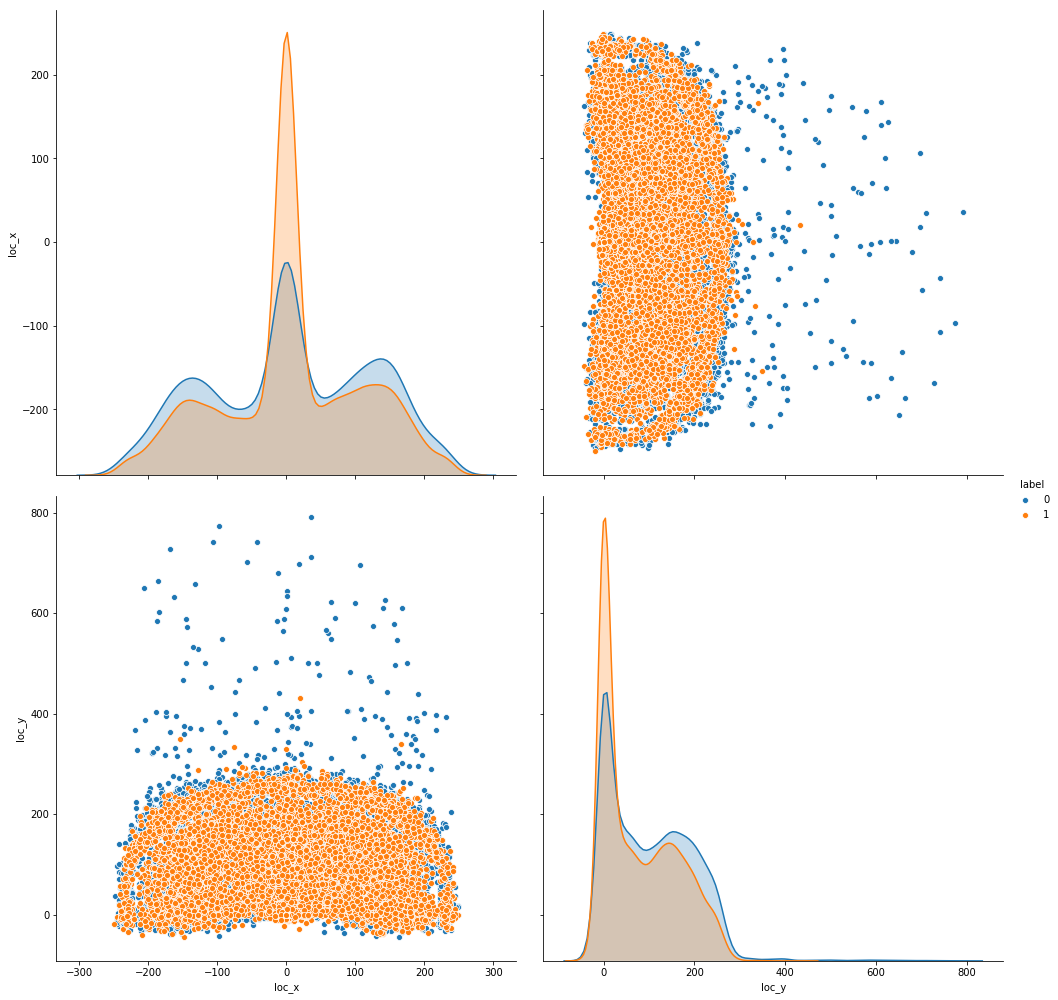

In [43]:
import seaborn as sns

numeric_data = new_df.select('loc_x','loc_y','label').toPandas()
sns.pairplot(numeric_data, vars=['loc_x', 'loc_y'], hue='label',height=7)


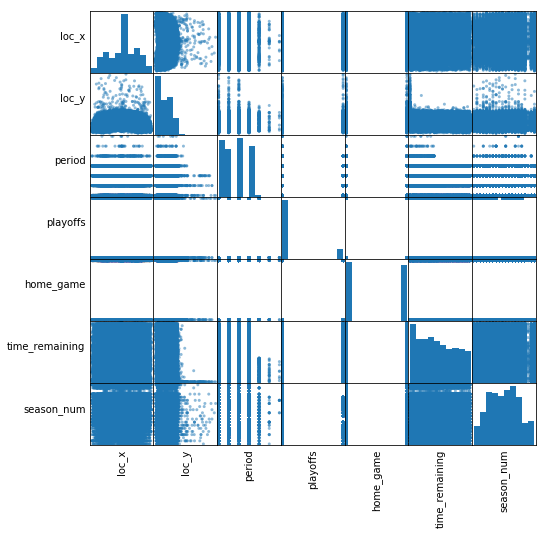

In [44]:
from pandas.plotting import scatter_matrix
#numeric_data = new_df.select('loc_x','loc_y','label').toPandas()
numeric_data = new_df.select(num_cols).toPandas()
axs = scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

### Data Distribution

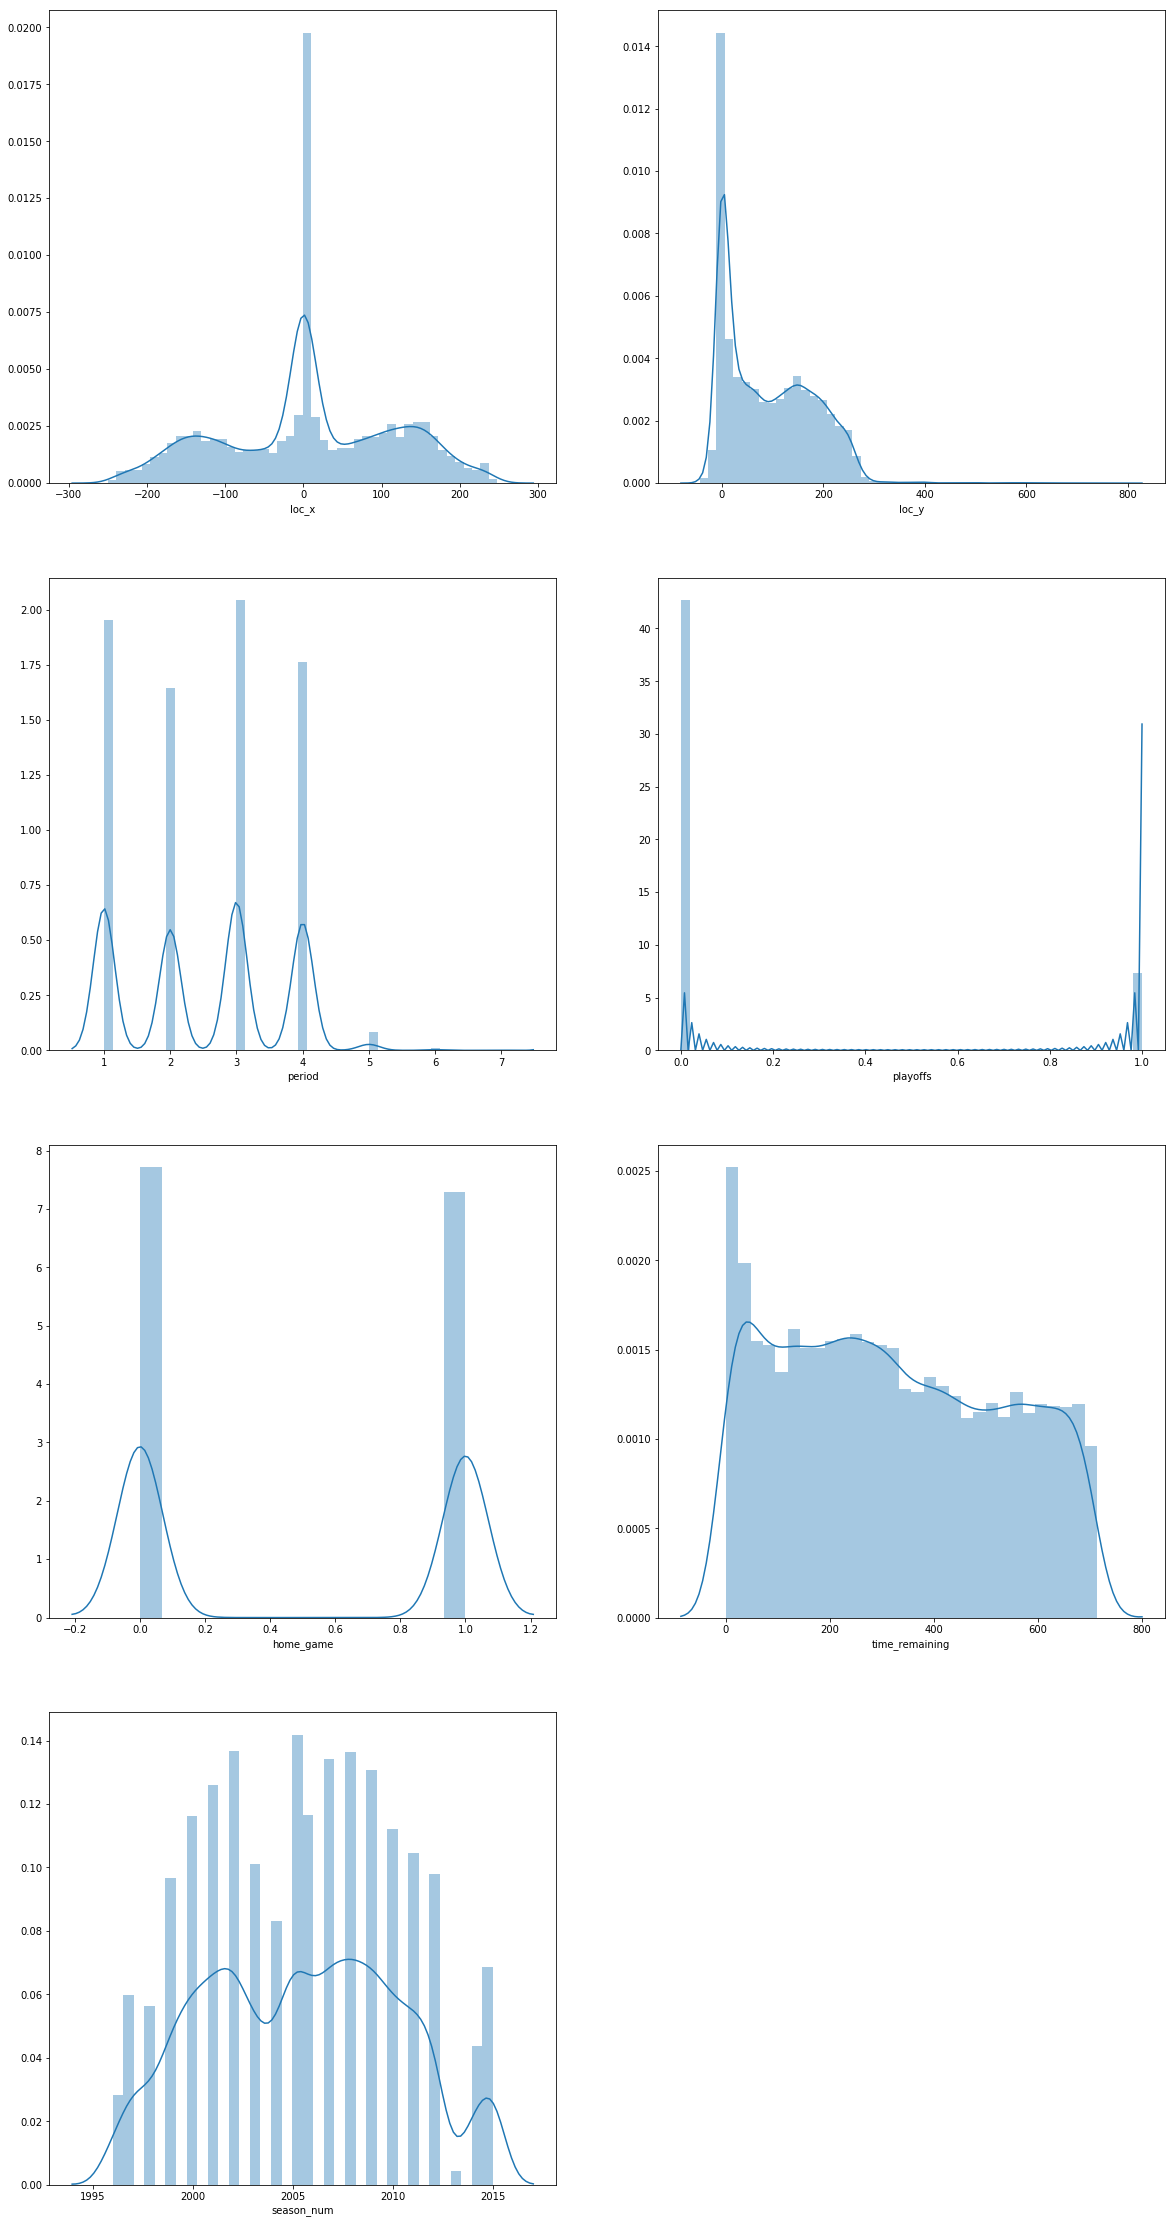

In [45]:
# Hereunder , we will analyse the distribution of the quantitative variables belong to the training data.
import seaborn as sns 
tr = new_df.toPandas()
fig=plt.figure(figsize=(20,40))
#variables=[tr['loc_x'],tr['loc_y']]
variables = [tr[v] for v in num_cols]
for i in range(len(variables)):
    fig.add_subplot(int(len(variables)/2)+1,2,i+1)
    sns.distplot(variables[i],kde=True)

### Look for Outliers

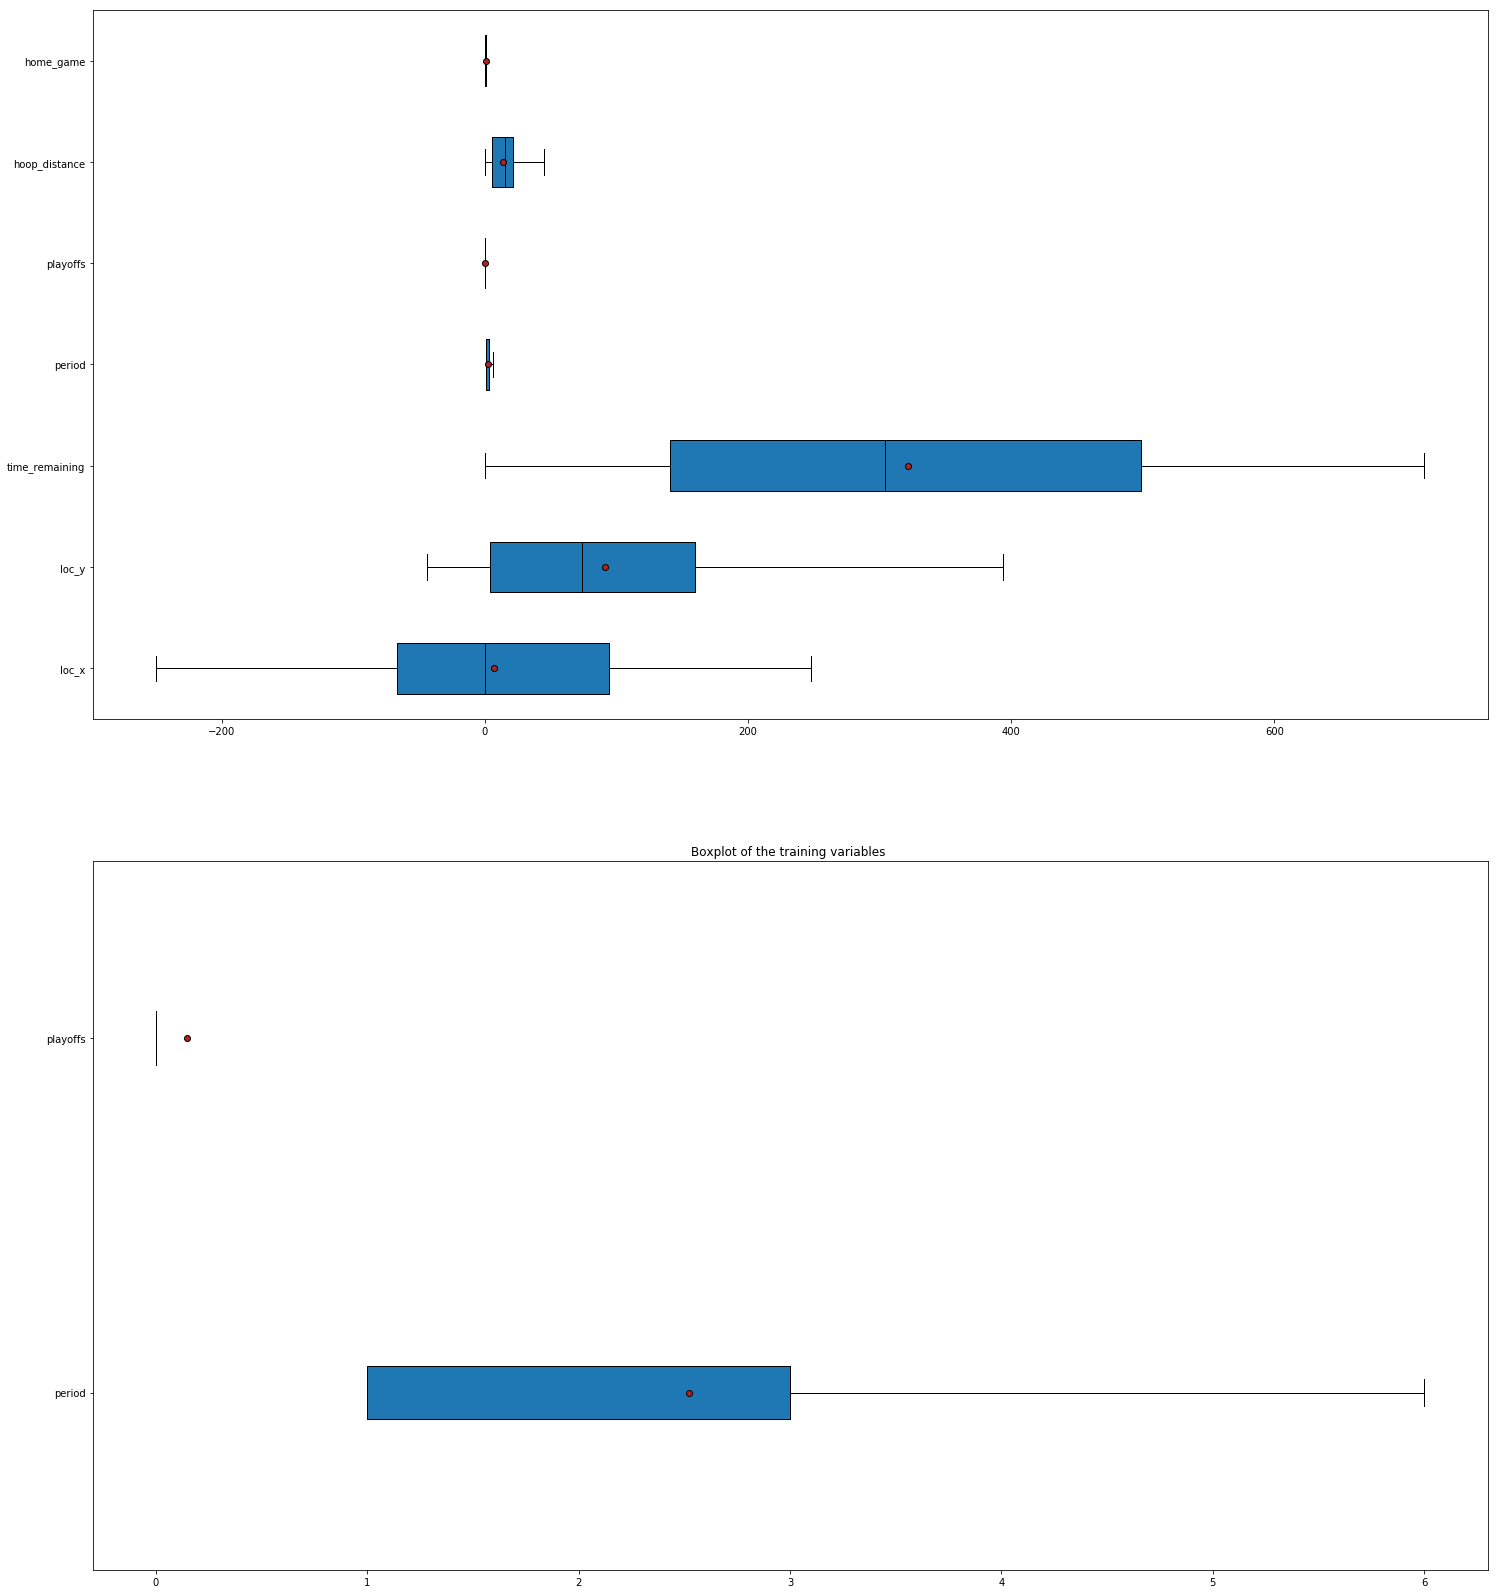

In [48]:
# Hereunder , we will show the boxplot of the quantitative variables of the training datas .
import matplotlib.pyplot as plt 
ind1=tr[tr['loc_x'].notna()==True].index
tr1=tr['loc_x'].iloc[ind1]
ind2=tr[tr['loc_y'].notna()==True].index
tr2=tr['loc_y'].iloc[ind2]
ind3=tr[tr['time_remaining'].notna()==True].index
tr3=tr['time_remaining'].iloc[ind3]
ind4=tr[tr['period'].notna()==True].index
tr4=tr['period'].iloc[ind4]
ind5=tr[tr['playoffs'].notna()==True].index
tr5=tr['playoffs'].iloc[ind5]

ind7=tr[tr['hoop_distance'].notna()==True].index
tr7=tr['hoop_distance'].iloc[ind5]

ind8=tr[tr['home_game'].notna()==True].index
tr8=tr['home_game'].iloc[ind5]

fig=plt.figure(figsize=(25,60))
fig.add_subplot(4,1,1)
var1=[tr1,tr2,tr3,tr4,tr5,tr7,tr8]
label1=['loc_x','loc_y','time_remaining','period','playoffs','hoop_distance','home_game']
medianprops={'color':"black"}
meanprops={'marker':'o','markeredgecolor':"black",'markerfacecolor':"firebrick"}
plt.boxplot(var1,labels=label1,vert=False,patch_artist=True,medianprops=medianprops,\
           meanprops=meanprops,showmeans=True,showfliers=False)
var2=[tr4,tr5]
label2=['period','playoffs']
fig.add_subplot(4,1,2)
plt.boxplot(var2,labels=label2,vert=False,patch_artist=True,medianprops=medianprops,\
           meanprops=meanprops,showmeans=True,showfliers=False)

plt.title('Boxplot of the training variables ')
plt.show()

In [49]:
# we use a pipeline to apply all the stages of tranformation to the data

from pyspark.ml import Pipeline
cols = new_df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(new_df)
new_df = pipelineModel.transform(new_df)

In [50]:
new_df.toPandas().head()

,action_type,loc_x,loc_y,period,playoffs,label,shot_type,shot_zone_area,shot_zone_basic,opponent,...,action_typeclassVec,shot_typeIndex,shot_typeclassVec,shot_zone_areaIndex,shot_zone_areaclassVec,shot_zone_basicIndex,shot_zone_basicclassVec,opponentIndex,opponentclassVec,features
0,Jump Shot,-157,0,1,0,0,2PT Field Goal,Left Side(L),Mid-Range,POR,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0)",4.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0)",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",5.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Jump Shot,-101,135,1,0,1,2PT Field Goal,Left Side Center(LC),Mid-Range,POR,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0)",3.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0)",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",5.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Jump Shot,138,175,1,0,0,2PT Field Goal,Right Side Center(RC),Mid-Range,POR,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0)",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",5.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Driving Dunk Shot,0,0,2,0,1,2PT Field Goal,Center(C),Restricted Area,POR,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",5.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Jump Shot,-145,-11,3,0,0,2PT Field Goal,Left Side(L),Mid-Range,POR,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0)",4.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0)",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",5.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [51]:
selectedCols = ['features']+cols
new_df = new_df.select(selectedCols)
pd.DataFrame(new_df.take(5), columns=new_df.columns)

,features,action_type,loc_x,loc_y,period,playoffs,label,shot_type,shot_zone_area,shot_zone_basic,opponent,home_game,time_remaining,season_num,hoop_distance
0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Jump Shot,-157,0,1,0,0,2PT Field Goal,Left Side(L),Mid-Range,POR,0,622,2000,15.700000
1,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Jump Shot,-101,135,1,0,1,2PT Field Goal,Left Side Center(LC),Mid-Range,POR,0,465,2000,16.860012
2,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Jump Shot,138,175,1,0,0,2PT Field Goal,Right Side Center(RC),Mid-Range,POR,0,412,2000,22.286543
3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Driving Dunk Shot,0,0,2,0,1,2PT Field Goal,Center(C),Restricted Area,POR,0,379,2000,0.000000
4,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Jump Shot,-145,-11,3,0,0,2PT Field Goal,Left Side(L),Mid-Range,POR,0,572,2000,14.541664


In [52]:
selectedCols

['features',
 'action_type',
 'loc_x',
 'loc_y',
 'period',
 'playoffs',
 'label',
 'shot_type',
 'shot_zone_area',
 'shot_zone_basic',
 'opponent',
 'home_game',
 'time_remaining',
 'season_num',
 'hoop_distance']

In [53]:
# split the data into training and testing sets

train, test = new_df.randomSplit([0.90, 0.10], seed = 53)
print(train.count())
print(test.count())

23163
2534


## Training models

In [54]:
# first we check how LogisticRegression performs 
from pyspark.ml.classification import LogisticRegression

LR = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=15)
LR_model = LR.fit(train)


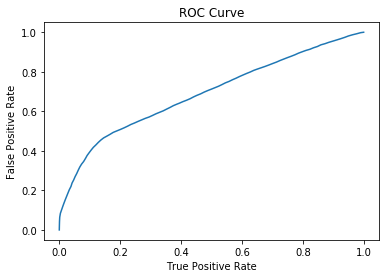

Training set ROC: 0.6884625361456189


In [55]:
#plotting the ROC Curve

trainingSummary = LR_model.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set ROC: ' + str(trainingSummary.areaUnderROC))

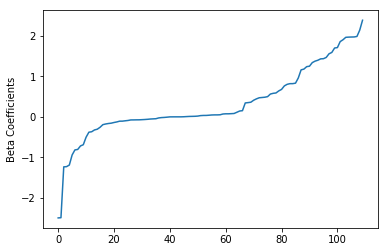

In [56]:

import numpy as np
beta = np.sort(LR_model.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [57]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions_LR = LR_model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET Area Under ROC: " + str(evaluator.evaluate(predictions_LR, {evaluator.metricName: "areaUnderROC"})))

Test_SET Area Under ROC: 0.6941063279688288


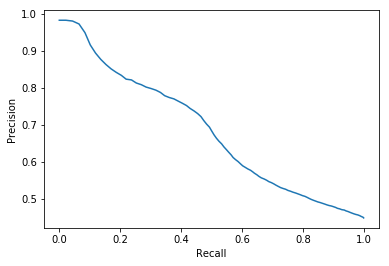

In [58]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [59]:
# next we checkout gradient boosting trees

from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=15)
GBT_Model = gbt.fit(train)
predictions = GBT_Model.transform(test)

In [60]:
evaluator = BinaryClassificationEvaluator()
print("Test_SET Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test_SET Area Under ROC: 0.7310819280017934


### Run the data thru a Cross Validator to find the best gbt model params

In [61]:
if True:
    from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

    paramGrid = (ParamGridBuilder()
                 .addGrid(gbt.maxDepth, [2, 4, 6])
                 .addGrid(gbt.maxBins, [20, 30])
                 .addGrid(gbt.maxIter, [10, 15])
                 .build())

    cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

    # Run cross validations.
    cvModel = cv.fit(train)
    predictions = cvModel.transform(test)
    evaluator.evaluate(predictions)

### Peek at test set predictions

In [63]:
predictions.select('shot_type','hoop_distance','label','prediction').limit(100).toPandas()

,shot_type,hoop_distance,label,prediction
0,2PT Field Goal,19.806313,0,0.0
1,2PT Field Goal,15.216110,0,0.0
2,2PT Field Goal,15.632018,0,0.0
3,2PT Field Goal,14.512064,0,0.0
4,2PT Field Goal,19.331322,0,0.0
5,2PT Field Goal,20.308865,0,0.0
6,2PT Field Goal,17.029387,1,0.0
7,2PT Field Goal,22.900219,0,0.0
8,2PT Field Goal,20.500000,1,0.0
9,2PT Field Goal,23.362577,0,0.0


### Peek at the validation set data

In [64]:
val_df.limit(10).toPandas()

,action_type,loc_x,loc_y,period,playoffs,label,shot_type,shot_zone_area,shot_zone_basic,opponent,home_game,time_remaining,season_num,hoop_distance
0,Jump Shot,167,72,1,0,None,2PT Field Goal,Right Side(R),Mid-Range,POR,0,627,2000,18.185984
1,Jump Shot,1,28,3,0,None,2PT Field Goal,Center(C),Restricted Area,POR,0,485,2000,2.801785
2,Driving Layup Shot,0,0,1,0,None,2PT Field Goal,Center(C),Restricted Area,UTA,1,1,2000,0.000000
3,Driving Layup Shot,0,0,3,0,None,2PT Field Goal,Center(C),Restricted Area,UTA,1,646,2000,0.000000
4,Jump Shot,163,76,1,0,None,2PT Field Goal,Right Side(R),Mid-Range,VAN,0,686,2000,17.984716
5,Jump Shot,70,194,1,0,None,2PT Field Goal,Right Side Center(RC),Mid-Range,VAN,0,658,2000,20.624258
6,Layup Shot,1,19,1,0,None,2PT Field Goal,Center(C),Restricted Area,VAN,0,453,2000,1.902630
7,Layup Shot,-12,15,1,0,None,2PT Field Goal,Center(C),Restricted Area,VAN,0,358,2000,1.920937
8,Reverse Layup Shot,1,4,1,0,None,2PT Field Goal,Center(C),Restricted Area,VAN,0,249,2000,0.412311
9,Jump Shot,-117,116,2,0,None,2PT Field Goal,Left Side Center(LC),Mid-Range,VAN,0,333,2000,16.475740


### Send the validation set (set used for the competition) thru the data transformation pipeline

In [65]:
transform_val_df = pipelineModel.transform(val_df)

In [66]:
transform_val_df.limit(10).toPandas()

,action_type,loc_x,loc_y,period,playoffs,label,shot_type,shot_zone_area,shot_zone_basic,opponent,...,action_typeclassVec,shot_typeIndex,shot_typeclassVec,shot_zone_areaIndex,shot_zone_areaclassVec,shot_zone_basicIndex,shot_zone_basicclassVec,opponentIndex,opponentclassVec,features
0,Jump Shot,167,72,1,0,None,2PT Field Goal,Right Side(R),Mid-Range,POR,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0)",2.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",5.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Jump Shot,1,28,3,0,None,2PT Field Goal,Center(C),Restricted Area,POR,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",5.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Driving Layup Shot,0,0,1,0,None,2PT Field Goal,Center(C),Restricted Area,UTA,...,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",6.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Driving Layup Shot,0,0,3,0,None,2PT Field Goal,Center(C),Restricted Area,UTA,...,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",6.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Jump Shot,163,76,1,0,None,2PT Field Goal,Right Side(R),Mid-Range,VAN,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0)",2.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",31.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,Jump Shot,70,194,1,0,None,2PT Field Goal,Right Side Center(RC),Mid-Range,VAN,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0)",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",31.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,Layup Shot,1,19,1,0,None,2PT Field Goal,Center(C),Restricted Area,VAN,...,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",31.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,Layup Shot,-12,15,1,0,None,2PT Field Goal,Center(C),Restricted Area,VAN,...,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",31.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,Reverse Layup Shot,1,4,1,0,None,2PT Field Goal,Center(C),Restricted Area,VAN,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",31.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,Jump Shot,-117,116,2,0,None,2PT Field Goal,Left Side Center(LC),Mid-Range,VAN,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0)",3.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0)",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",31.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [67]:
transform_val_df = transform_val_df.drop('label')

### Create Predictions based on the GBT Model

In [68]:
val_predictions = GBT_Model.transform(transform_val_df)

In [73]:
cv_predictions = cvModel.transform(transform_val_df)

In [72]:
val_predictions.toPandas().describe().T

,count,mean,std,min,25%,50%,75%,max
loc_x,5000.0,6.915600,110.399352,-246.0,-71.000000,0.000000,96.250000,241.000000
loc_y,5000.0,90.337600,85.917998,-42.0,4.000000,76.000000,157.000000,592.000000
period,5000.0,2.512400,1.164181,1.0,1.000000,3.000000,4.000000,6.000000
playoffs,5000.0,0.148200,0.355334,0.0,0.000000,0.000000,0.000000,1.000000
home_game,5000.0,0.494200,0.500016,0.0,0.000000,0.000000,1.000000,1.000000
time_remaining,5000.0,321.416200,207.496080,0.0,143.000000,307.500000,495.000000,710.000000
season_num,5000.0,2005.296200,4.907105,1996.0,2001.000000,2005.000000,2009.000000,2015.000000
hoop_distance,5000.0,13.749185,9.419413,0.0,4.900765,15.616017,20.936092,61.298042
action_typeIndex,5000.0,2.582400,5.829546,0.0,0.000000,0.000000,2.000000,55.000000
shot_typeIndex,5000.0,0.202800,0.402125,0.0,0.000000,0.000000,0.000000,1.000000


In [74]:
cv_predictions.toPandas().describe().T

,count,mean,std,min,25%,50%,75%,max
loc_x,5000.0,6.915600,110.399352,-246.0,-71.000000,0.000000,96.250000,241.000000
loc_y,5000.0,90.337600,85.917998,-42.0,4.000000,76.000000,157.000000,592.000000
period,5000.0,2.512400,1.164181,1.0,1.000000,3.000000,4.000000,6.000000
playoffs,5000.0,0.148200,0.355334,0.0,0.000000,0.000000,0.000000,1.000000
home_game,5000.0,0.494200,0.500016,0.0,0.000000,0.000000,1.000000,1.000000
time_remaining,5000.0,321.416200,207.496080,0.0,143.000000,307.500000,495.000000,710.000000
season_num,5000.0,2005.296200,4.907105,1996.0,2001.000000,2005.000000,2009.000000,2015.000000
hoop_distance,5000.0,13.749185,9.419413,0.0,4.900765,15.616017,20.936092,61.298042
action_typeIndex,5000.0,2.582400,5.829546,0.0,0.000000,0.000000,2.000000,55.000000
shot_typeIndex,5000.0,0.202800,0.402125,0.0,0.000000,0.000000,0.000000,1.000000


### Take a peek at some predictions

In [ ]:
val_predictions.select('action_type','shot_zone_area','shot_distance','opponent','home_game','prediction').limit(100).toPandas()
#val_predictions.select('features').toPandas()

### Save the best model if using Cross-Validation or save the only model if using stright Gradient Boost

In [76]:
try:
    cvModel.bestModel.save('kobe2.gt')
    cvModel.save('kobe2.gbt.model')
except NameError:
    GBT_Model.save('kobe2.gbt.model')

### Save the predicitons in the form (shot_id, prediciton) in a single .csv file

In [ ]:
val_predictions.select('shot_id','prediction').coalesce(1).write.csv('kobe.predictions.csv',header=True)

In [ ]:
val_predictions.select('shot_id','prediction').limit(10).toPandas()